# Downloading and displaying images of stellar clusters

In this notebook, we will download FFIs of several stellar clusters using TESScut and display them with matplotlib. The clusters we will be working with are:

- IC 4725 (missing END card) (no sectors available)
- M34 (Internal Server Error)
- Pleiades (missing END card) (no sectors available)
- M7 (Internal Server Error)
- NGC 752 (Internal Server Error) 
- IC 4665 (missing END card) (no sectors available)
- M24 (missing END card) (no sectors available)
- IC 2391
- Omega Cen (Internal Server Error)
- 47 Tuc (Internal Server Error)
- M4 (missing END card) (no sectors available)
- NGC 6752 (Internal Server Error)

This is a companion to the cluster-lightcurves notebook, which takes a different approach. This approach pulls FFIs from the TESScut website and loads them to get images of an arbitrary size, focused on certain clusters. It is flexible because you can get any size you want, but it doesn't have any processing tools like `eleanor` has, and I haven't gotten it to work.

**Please note** that I edited the documentation of astropy to allow a timeout parameter to be passed to fits.open. If you do not also edit the code in this way, some FITS files may not be downloaded because they are too big. You could solve this either by downloading them via browser or some other method, or by editing the documentation yourself.

If you choose the second option, go throug the error stack until you see errors emerging from your python install's version of _urllib/request.py_. One of the functions that throws the error in this file should have an argument called timeout. Simply edit all the astropy functions higher in the stack so that a timeout argument is passed down from `fits.open` all the way to the urllib function.

In [42]:
%matplotlib inline
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np

DEGREES = 1
POSITIONS = {"IC 4725":(277.94486, -19.11496), "M34":(40.53083, 42.74615), "Pleiades":(56.86909, 24.10531), 
             "M7":(268.46325, -34.79283), "NGC 752":(29.421, 37.785), "IC 4665": (266.61324, 5.64874),
             "M24": (274.23385, -18.51456), "IC 2391": (130.133, -53.033), "Omega Cen": (201.69121, -47.47686),
             "47 Tuc": (6.022329, -72.081444), "M4": (245.89675, -26.52575), "NGC 6752": (287.71575, -59.98185)}
SECTOR = {"IC 2391":8}
def getSector(name):
    if name in SECTOR:
        return SECTOR[NAME]
    return "All:"

In [43]:
NAME = "IC 2391"

USE_WEB = True

if USE_WEB:
    fits_file = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={0}&dec={1}&y={2}&x={2}&units=d&sector={3}".format(
        POSITIONS[NAME][0], POSITIONS[NAME][1], DEGREES, getSector(NAME))
else:
    fits_file = "file:///mnt/c/Users/goods/Desktop/REU/github/photometry-age-dating/ffis/" + NAME + " (2).fits"

print(fits_file)

https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=130.133&dec=-53.033&y=1&x=1&units=d&sector=8


Open the file, load the image data, and close it.

In [44]:
with fits.open(fits_file, mode = "readonly", timeout=100) as hdulist:
    fits.info(fits_file)
    wcs_info = WCS(hdulist[1].header)
    cal_image = hdulist[1].data['FLUX']
    header = hdulist[1].header
    
#mid_time = 0.5 * (header['TSTOP'] + header['TSTART'])# Use the middle of the exposure
frameIndex = int(0.5 * cal_image.shape[0])

Filename: /home/jtdinsmo/.astropy/cache/download/py3/85f4f7b5d3fb17f5b6d89eddf4137c14
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   ()      
  1  PIXELS        1 BinTableHDU    280   968R x 12C   [D, E, J, 30625J, 30625E, 30625E, 30625E, 30625E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        80   (175, 175)   int32   


Now we can display the ffis:

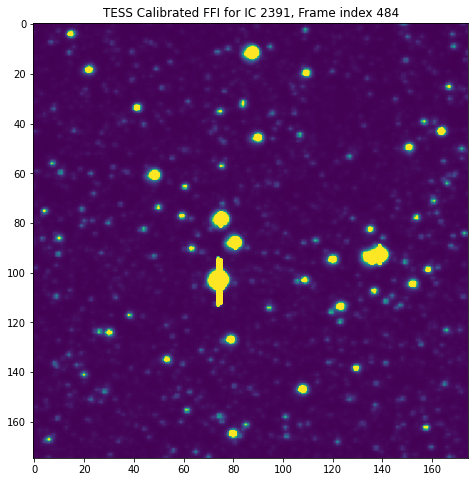

In [45]:
plt.figure(figsize = (8,8))

BRIGHTNESS_PERCENTILES = {"M7":[20, 100], "NGC 752":[0, 99], "IC 2391":[0, 99]}# Not sure what the last number does
def get_brightness():
    if NAME in BRIGHTNESS_PERCENTILES:
        return BRIGHTNESS_PERCENTILES[NAME]
    return [4, 98]

#plt.subplot(111, projection = wcs_info)
plt.imshow(cal_image[frameIndex], vmin = np.nanpercentile(cal_image[frameIndex],get_brightness()[0]),
           vmax = np.nanpercentile(cal_image[frameIndex], get_brightness()[1]))
plt.title("TESS Calibrated FFI for " + NAME + ", Frame index %i" % frameIndex);

IC 2391 worked, but the rest threw errors. I was able to diagnose the errors:

- `timeout: The read operation timed out` happens when you try to summon an image that's too big. Just increase the timeout argument and make sure that you read the Please Note section at the beginning of this notebook.
- `OSError: Header missing END card` means that no TESS sectors contain these objects. The TESScut website can't access them either, and `eleanor` says that TESS hasn't observed the object yet

but not this error:

- `HTTP Error 500: Internal Server Error` happens sometimes. You can fix it by going to the TESScut website and just downloading the (huge) file, but they're mostly full of nans. (I also don't know why the compression doesn't seem to suppress the nans. Am I not downloading the right files?)
    - Update: for the one cluster that works, when I use the TESScut website to download the FFI for that, I get a real image, not one filled with nans. So the problem is not that I'm downloading the wrong file; I think it's a TESScut glitch. And yet eleanor seems to be able to overcome it for small images.